In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random 

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset

from torch.utils.tensorboard import SummaryWriter



import csv


In [2]:
def create_curve(freq, ampl, freq_noise, ampl_noise, window_size):
    freq = random.gauss(freq, freq_noise) #add noise to frequency
    ampl = random.gauss(ampl, ampl_noise) #add noise to amplitude
    time = np.linspace(0, 10*np.pi, window_size)
    x = ampl*np.cos(freq*time)
    noise = np.random.normal(random.uniform(-1,0), random.uniform(0,1), window_size)
    x+=noise
    x = np.expand_dims(x, axis = 0) #expand to get 2d array (features, window length)
    x = np.expand_dims(x, axis = 0) #expand to get 3d array to store 2d elements
    #print(f"freq: {freq}, ampl:{ampl}")
    #plt.plot(time, x[0,0,:])
    #plt.show()
    
    return x

def create_data_window(n, frequencies, amplitudes, freq_noise, ampl_noise, window_size):
   
    X_data_class_1_domain_1 = np.empty((0,1,window_size))
    X_data_class_2_domain_1 = np.empty((0,1,window_size))
    X_data_class_1_domain_2 = np.empty((0,1,window_size))
    X_data_class_2_domain_2 = np.empty((0,1,window_size))
    
    for i in range(n):
        X_data_class_1_domain_1 = np.append(X_data_class_1_domain_1, create_curve(frequencies[0], amplitudes[0], freq_noise, ampl_noise, window_size), axis = 0) 
        X_data_class_2_domain_1 = np.append(X_data_class_2_domain_1, create_curve(frequencies[1], amplitudes[1], freq_noise, ampl_noise, window_size), axis = 0)
        X_data_class_1_domain_2 = np.append(X_data_class_1_domain_2, create_curve(frequencies[2], amplitudes[2], freq_noise, ampl_noise, window_size), axis = 0)
        X_data_class_2_domain_2 = np.append(X_data_class_2_domain_2, create_curve(frequencies[3], amplitudes[3], freq_noise, ampl_noise, window_size), axis = 0)
        print(f"Data loaded: {i+1}/{n}")
        #print(i)
        #print((X_data_class_1_domain_1))
        
    n_samples = np.shape(X_data_class_2_domain_1)[0]*2  
    
    y_data_class_1_domain_1 = np.asarray([0]*np.shape(X_data_class_1_domain_1)[0])
    y_data_class_2_domain_1 = np.asarray([1]*np.shape(X_data_class_2_domain_1)[0])
    y_data_class_1_domain_2 = np.asarray([0]*np.shape(X_data_class_1_domain_2)[0])
    y_data_class_2_domain_2 = np.asarray([1]*np.shape(X_data_class_2_domain_2)[0])
    
    X_data_source = np.concatenate((X_data_class_1_domain_1, X_data_class_2_domain_1), axis = 0)
    y_data_source = np.concatenate((y_data_class_1_domain_1, y_data_class_2_domain_1), axis = 0)
    X_data_target = np.concatenate((X_data_class_1_domain_2, X_data_class_2_domain_2), axis = 0)
    y_data_target = np.concatenate((y_data_class_1_domain_2, y_data_class_2_domain_2), axis = 0)
    
    
    X_data_source = torch.from_numpy(X_data_source)
    y_data_source = torch.from_numpy(y_data_source)
    X_data_target = torch.from_numpy(X_data_target)
    y_data_target = torch.from_numpy(y_data_target)
    
    return n_samples, X_data_source, y_data_source, X_data_target, y_data_target
"""
#TEST
frequencies = [1,4,1.4,3.6]
amplitudes = [6,2,5,4]
freq_noise = 0.3
ampl_noise = 2
window_size = 1000
n_samples, X_data_source, y_data_source, X_data_target, y_data_target = create_data_window(1000, frequencies, amplitudes, freq_noise, ampl_noise, window_size)
"""

'\n#TEST\nfrequencies = [1,4,1.4,3.6]\namplitudes = [6,2,5,4]\nfreq_noise = 0.3\nampl_noise = 2\nwindow_size = 1000\nn_samples, X_data_source, y_data_source, X_data_target, y_data_target = create_data_window(1000, frequencies, amplitudes, freq_noise, ampl_noise, window_size)\n'

In [3]:
class Dataset_Dummy_Source_Window(Dataset):

    
    
    def __init__(self):

        n = 2000
        frequencies = [1,4,2,3]#[1,4,1.6,3.4]
        amplitudes = [6,2,5,4]
        freq_noise = 0.5
        ampl_noise = 2
        window_size = 1000
        self.n_samples, self.x_data, self.y_data, _, _ = create_data_window(n, frequencies, amplitudes, freq_noise, ampl_noise, window_size)
        
        
                  
    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

class Dataset_Dummy_Target_Window(Dataset):

    
    
    def __init__(self):

        n = 2000
        frequencies = [1,4,1.6,3.4]
        amplitudes = [6,2,5,4]
        freq_noise = 0.5
        ampl_noise = 2
        window_size = 1000
        self.n_samples, _, _, self.x_data, self.y_data = create_data_window(n, frequencies, amplitudes, freq_noise, ampl_noise, window_size)
        
        
                  
    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples

In [4]:
#dataloader

dataset_source = Dataset_Dummy_Source_Window()

# define train/val dimensions
train_size_source = int(0.8 * len(dataset_source))
validation_size_source = len(dataset_source) - train_size_source

training_dataset_source, validation_dataset_source = torch.utils.data.random_split(dataset_source, [train_size_source, validation_size_source])
batch_size = 64
train_loader_source = DataLoader(dataset=training_dataset_source,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)
validation_loader_source = DataLoader(dataset=validation_dataset_source,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)





dataset_target = Dataset_Dummy_Target_Window()

# define train/val dimensions
train_size_target = int(0.8 * len(dataset_target))
validation_size_target = len(dataset_target) - train_size_target

training_dataset_target, validation_dataset_target = torch.utils.data.random_split(dataset_target, [train_size_target, validation_size_target])
batch_size = 64
train_loader_target = DataLoader(dataset=training_dataset_target,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)
validation_loader_target = DataLoader(dataset=validation_dataset_target,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=2)

source_loader = {}
source_loader["train"] = train_loader_source
source_loader["val"] = validation_loader_source

target_loader = {}
target_loader["test"] = train_loader_target
target_loader["val"] = validation_loader_target

Data loaded: 1/2000
Data loaded: 2/2000
Data loaded: 3/2000
Data loaded: 4/2000
Data loaded: 5/2000
Data loaded: 6/2000
Data loaded: 7/2000
Data loaded: 8/2000
Data loaded: 9/2000
Data loaded: 10/2000
Data loaded: 11/2000
Data loaded: 12/2000
Data loaded: 13/2000
Data loaded: 14/2000
Data loaded: 15/2000
Data loaded: 16/2000
Data loaded: 17/2000
Data loaded: 18/2000
Data loaded: 19/2000
Data loaded: 20/2000
Data loaded: 21/2000
Data loaded: 22/2000
Data loaded: 23/2000
Data loaded: 24/2000
Data loaded: 25/2000
Data loaded: 26/2000
Data loaded: 27/2000
Data loaded: 28/2000
Data loaded: 29/2000
Data loaded: 30/2000
Data loaded: 31/2000
Data loaded: 32/2000
Data loaded: 33/2000
Data loaded: 34/2000
Data loaded: 35/2000
Data loaded: 36/2000
Data loaded: 37/2000
Data loaded: 38/2000
Data loaded: 39/2000
Data loaded: 40/2000
Data loaded: 41/2000
Data loaded: 42/2000
Data loaded: 43/2000
Data loaded: 44/2000
Data loaded: 45/2000
Data loaded: 46/2000
Data loaded: 47/2000
Data loaded: 48/2000
D

Data loaded: 395/2000
Data loaded: 396/2000
Data loaded: 397/2000
Data loaded: 398/2000
Data loaded: 399/2000
Data loaded: 400/2000
Data loaded: 401/2000
Data loaded: 402/2000
Data loaded: 403/2000
Data loaded: 404/2000
Data loaded: 405/2000
Data loaded: 406/2000
Data loaded: 407/2000
Data loaded: 408/2000
Data loaded: 409/2000
Data loaded: 410/2000
Data loaded: 411/2000
Data loaded: 412/2000
Data loaded: 413/2000
Data loaded: 414/2000
Data loaded: 415/2000
Data loaded: 416/2000
Data loaded: 417/2000
Data loaded: 418/2000
Data loaded: 419/2000
Data loaded: 420/2000
Data loaded: 421/2000
Data loaded: 422/2000
Data loaded: 423/2000
Data loaded: 424/2000
Data loaded: 425/2000
Data loaded: 426/2000
Data loaded: 427/2000
Data loaded: 428/2000
Data loaded: 429/2000
Data loaded: 430/2000
Data loaded: 431/2000
Data loaded: 432/2000
Data loaded: 433/2000
Data loaded: 434/2000
Data loaded: 435/2000
Data loaded: 436/2000
Data loaded: 437/2000
Data loaded: 438/2000
Data loaded: 439/2000
Data loade

Data loaded: 768/2000
Data loaded: 769/2000
Data loaded: 770/2000
Data loaded: 771/2000
Data loaded: 772/2000
Data loaded: 773/2000
Data loaded: 774/2000
Data loaded: 775/2000
Data loaded: 776/2000
Data loaded: 777/2000
Data loaded: 778/2000
Data loaded: 779/2000
Data loaded: 780/2000
Data loaded: 781/2000
Data loaded: 782/2000
Data loaded: 783/2000
Data loaded: 784/2000
Data loaded: 785/2000
Data loaded: 786/2000
Data loaded: 787/2000
Data loaded: 788/2000
Data loaded: 789/2000
Data loaded: 790/2000
Data loaded: 791/2000
Data loaded: 792/2000
Data loaded: 793/2000
Data loaded: 794/2000
Data loaded: 795/2000
Data loaded: 796/2000
Data loaded: 797/2000
Data loaded: 798/2000
Data loaded: 799/2000
Data loaded: 800/2000
Data loaded: 801/2000
Data loaded: 802/2000
Data loaded: 803/2000
Data loaded: 804/2000
Data loaded: 805/2000
Data loaded: 806/2000
Data loaded: 807/2000
Data loaded: 808/2000
Data loaded: 809/2000
Data loaded: 810/2000
Data loaded: 811/2000
Data loaded: 812/2000
Data loade

Data loaded: 1144/2000
Data loaded: 1145/2000
Data loaded: 1146/2000
Data loaded: 1147/2000
Data loaded: 1148/2000
Data loaded: 1149/2000
Data loaded: 1150/2000
Data loaded: 1151/2000
Data loaded: 1152/2000
Data loaded: 1153/2000
Data loaded: 1154/2000
Data loaded: 1155/2000
Data loaded: 1156/2000
Data loaded: 1157/2000
Data loaded: 1158/2000
Data loaded: 1159/2000
Data loaded: 1160/2000
Data loaded: 1161/2000
Data loaded: 1162/2000
Data loaded: 1163/2000
Data loaded: 1164/2000
Data loaded: 1165/2000
Data loaded: 1166/2000
Data loaded: 1167/2000
Data loaded: 1168/2000
Data loaded: 1169/2000
Data loaded: 1170/2000
Data loaded: 1171/2000
Data loaded: 1172/2000
Data loaded: 1173/2000
Data loaded: 1174/2000
Data loaded: 1175/2000
Data loaded: 1176/2000
Data loaded: 1177/2000
Data loaded: 1178/2000
Data loaded: 1179/2000
Data loaded: 1180/2000
Data loaded: 1181/2000
Data loaded: 1182/2000
Data loaded: 1183/2000
Data loaded: 1184/2000
Data loaded: 1185/2000
Data loaded: 1186/2000
Data loaded

Data loaded: 1502/2000
Data loaded: 1503/2000
Data loaded: 1504/2000
Data loaded: 1505/2000
Data loaded: 1506/2000
Data loaded: 1507/2000
Data loaded: 1508/2000
Data loaded: 1509/2000
Data loaded: 1510/2000
Data loaded: 1511/2000
Data loaded: 1512/2000
Data loaded: 1513/2000
Data loaded: 1514/2000
Data loaded: 1515/2000
Data loaded: 1516/2000
Data loaded: 1517/2000
Data loaded: 1518/2000
Data loaded: 1519/2000
Data loaded: 1520/2000
Data loaded: 1521/2000
Data loaded: 1522/2000
Data loaded: 1523/2000
Data loaded: 1524/2000
Data loaded: 1525/2000
Data loaded: 1526/2000
Data loaded: 1527/2000
Data loaded: 1528/2000
Data loaded: 1529/2000
Data loaded: 1530/2000
Data loaded: 1531/2000
Data loaded: 1532/2000
Data loaded: 1533/2000
Data loaded: 1534/2000
Data loaded: 1535/2000
Data loaded: 1536/2000
Data loaded: 1537/2000
Data loaded: 1538/2000
Data loaded: 1539/2000
Data loaded: 1540/2000
Data loaded: 1541/2000
Data loaded: 1542/2000
Data loaded: 1543/2000
Data loaded: 1544/2000
Data loaded

Data loaded: 1860/2000
Data loaded: 1861/2000
Data loaded: 1862/2000
Data loaded: 1863/2000
Data loaded: 1864/2000
Data loaded: 1865/2000
Data loaded: 1866/2000
Data loaded: 1867/2000
Data loaded: 1868/2000
Data loaded: 1869/2000
Data loaded: 1870/2000
Data loaded: 1871/2000
Data loaded: 1872/2000
Data loaded: 1873/2000
Data loaded: 1874/2000
Data loaded: 1875/2000
Data loaded: 1876/2000
Data loaded: 1877/2000
Data loaded: 1878/2000
Data loaded: 1879/2000
Data loaded: 1880/2000
Data loaded: 1881/2000
Data loaded: 1882/2000
Data loaded: 1883/2000
Data loaded: 1884/2000
Data loaded: 1885/2000
Data loaded: 1886/2000
Data loaded: 1887/2000
Data loaded: 1888/2000
Data loaded: 1889/2000
Data loaded: 1890/2000
Data loaded: 1891/2000
Data loaded: 1892/2000
Data loaded: 1893/2000
Data loaded: 1894/2000
Data loaded: 1895/2000
Data loaded: 1896/2000
Data loaded: 1897/2000
Data loaded: 1898/2000
Data loaded: 1899/2000
Data loaded: 1900/2000
Data loaded: 1901/2000
Data loaded: 1902/2000
Data loaded

Data loaded: 241/2000
Data loaded: 242/2000
Data loaded: 243/2000
Data loaded: 244/2000
Data loaded: 245/2000
Data loaded: 246/2000
Data loaded: 247/2000
Data loaded: 248/2000
Data loaded: 249/2000
Data loaded: 250/2000
Data loaded: 251/2000
Data loaded: 252/2000
Data loaded: 253/2000
Data loaded: 254/2000
Data loaded: 255/2000
Data loaded: 256/2000
Data loaded: 257/2000
Data loaded: 258/2000
Data loaded: 259/2000
Data loaded: 260/2000
Data loaded: 261/2000
Data loaded: 262/2000
Data loaded: 263/2000
Data loaded: 264/2000
Data loaded: 265/2000
Data loaded: 266/2000
Data loaded: 267/2000
Data loaded: 268/2000
Data loaded: 269/2000
Data loaded: 270/2000
Data loaded: 271/2000
Data loaded: 272/2000
Data loaded: 273/2000
Data loaded: 274/2000
Data loaded: 275/2000
Data loaded: 276/2000
Data loaded: 277/2000
Data loaded: 278/2000
Data loaded: 279/2000
Data loaded: 280/2000
Data loaded: 281/2000
Data loaded: 282/2000
Data loaded: 283/2000
Data loaded: 284/2000
Data loaded: 285/2000
Data loade

Data loaded: 618/2000
Data loaded: 619/2000
Data loaded: 620/2000
Data loaded: 621/2000
Data loaded: 622/2000
Data loaded: 623/2000
Data loaded: 624/2000
Data loaded: 625/2000
Data loaded: 626/2000
Data loaded: 627/2000
Data loaded: 628/2000
Data loaded: 629/2000
Data loaded: 630/2000
Data loaded: 631/2000
Data loaded: 632/2000
Data loaded: 633/2000
Data loaded: 634/2000
Data loaded: 635/2000
Data loaded: 636/2000
Data loaded: 637/2000
Data loaded: 638/2000
Data loaded: 639/2000
Data loaded: 640/2000
Data loaded: 641/2000
Data loaded: 642/2000
Data loaded: 643/2000
Data loaded: 644/2000
Data loaded: 645/2000
Data loaded: 646/2000
Data loaded: 647/2000
Data loaded: 648/2000
Data loaded: 649/2000
Data loaded: 650/2000
Data loaded: 651/2000
Data loaded: 652/2000
Data loaded: 653/2000
Data loaded: 654/2000
Data loaded: 655/2000
Data loaded: 656/2000
Data loaded: 657/2000
Data loaded: 658/2000
Data loaded: 659/2000
Data loaded: 660/2000
Data loaded: 661/2000
Data loaded: 662/2000
Data loade

Data loaded: 997/2000
Data loaded: 998/2000
Data loaded: 999/2000
Data loaded: 1000/2000
Data loaded: 1001/2000
Data loaded: 1002/2000
Data loaded: 1003/2000
Data loaded: 1004/2000
Data loaded: 1005/2000
Data loaded: 1006/2000
Data loaded: 1007/2000
Data loaded: 1008/2000
Data loaded: 1009/2000
Data loaded: 1010/2000
Data loaded: 1011/2000
Data loaded: 1012/2000
Data loaded: 1013/2000
Data loaded: 1014/2000
Data loaded: 1015/2000
Data loaded: 1016/2000
Data loaded: 1017/2000
Data loaded: 1018/2000
Data loaded: 1019/2000
Data loaded: 1020/2000
Data loaded: 1021/2000
Data loaded: 1022/2000
Data loaded: 1023/2000
Data loaded: 1024/2000
Data loaded: 1025/2000
Data loaded: 1026/2000
Data loaded: 1027/2000
Data loaded: 1028/2000
Data loaded: 1029/2000
Data loaded: 1030/2000
Data loaded: 1031/2000
Data loaded: 1032/2000
Data loaded: 1033/2000
Data loaded: 1034/2000
Data loaded: 1035/2000
Data loaded: 1036/2000
Data loaded: 1037/2000
Data loaded: 1038/2000
Data loaded: 1039/2000
Data loaded: 1

Data loaded: 1357/2000
Data loaded: 1358/2000
Data loaded: 1359/2000
Data loaded: 1360/2000
Data loaded: 1361/2000
Data loaded: 1362/2000
Data loaded: 1363/2000
Data loaded: 1364/2000
Data loaded: 1365/2000
Data loaded: 1366/2000
Data loaded: 1367/2000
Data loaded: 1368/2000
Data loaded: 1369/2000
Data loaded: 1370/2000
Data loaded: 1371/2000
Data loaded: 1372/2000
Data loaded: 1373/2000
Data loaded: 1374/2000
Data loaded: 1375/2000
Data loaded: 1376/2000
Data loaded: 1377/2000
Data loaded: 1378/2000
Data loaded: 1379/2000
Data loaded: 1380/2000
Data loaded: 1381/2000
Data loaded: 1382/2000
Data loaded: 1383/2000
Data loaded: 1384/2000
Data loaded: 1385/2000
Data loaded: 1386/2000
Data loaded: 1387/2000
Data loaded: 1388/2000
Data loaded: 1389/2000
Data loaded: 1390/2000
Data loaded: 1391/2000
Data loaded: 1392/2000
Data loaded: 1393/2000
Data loaded: 1394/2000
Data loaded: 1395/2000
Data loaded: 1396/2000
Data loaded: 1397/2000
Data loaded: 1398/2000
Data loaded: 1399/2000
Data loaded

Data loaded: 1716/2000
Data loaded: 1717/2000
Data loaded: 1718/2000
Data loaded: 1719/2000
Data loaded: 1720/2000
Data loaded: 1721/2000
Data loaded: 1722/2000
Data loaded: 1723/2000
Data loaded: 1724/2000
Data loaded: 1725/2000
Data loaded: 1726/2000
Data loaded: 1727/2000
Data loaded: 1728/2000
Data loaded: 1729/2000
Data loaded: 1730/2000
Data loaded: 1731/2000
Data loaded: 1732/2000
Data loaded: 1733/2000
Data loaded: 1734/2000
Data loaded: 1735/2000
Data loaded: 1736/2000
Data loaded: 1737/2000
Data loaded: 1738/2000
Data loaded: 1739/2000
Data loaded: 1740/2000
Data loaded: 1741/2000
Data loaded: 1742/2000
Data loaded: 1743/2000
Data loaded: 1744/2000
Data loaded: 1745/2000
Data loaded: 1746/2000
Data loaded: 1747/2000
Data loaded: 1748/2000
Data loaded: 1749/2000
Data loaded: 1750/2000
Data loaded: 1751/2000
Data loaded: 1752/2000
Data loaded: 1753/2000
Data loaded: 1754/2000
Data loaded: 1755/2000
Data loaded: 1756/2000
Data loaded: 1757/2000
Data loaded: 1758/2000
Data loaded

50


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


tensor(0)


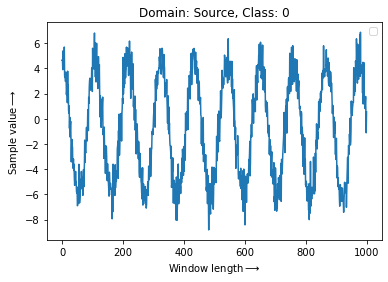

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


tensor(0)


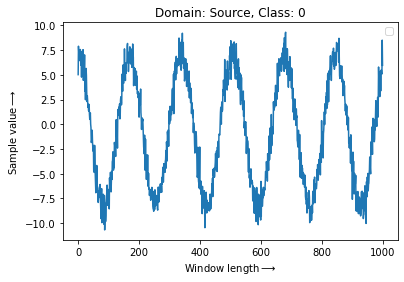

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


tensor(1)


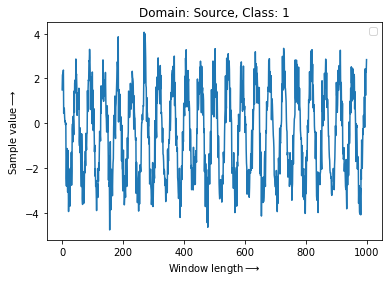

tensor(0)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


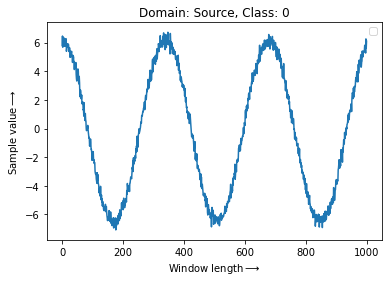

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


tensor(0)


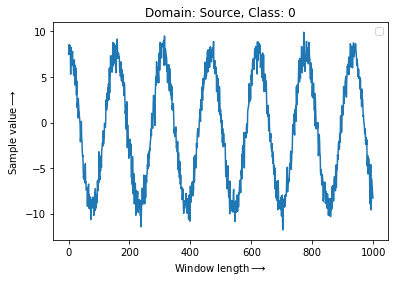

tensor(1)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


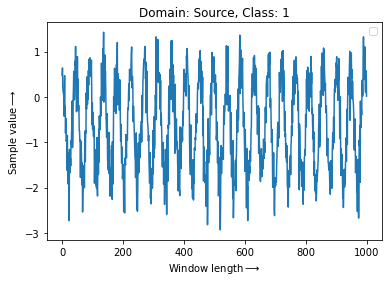

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


tensor(0)


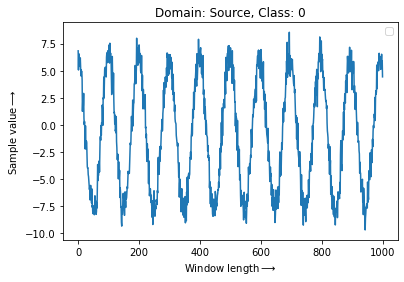

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


tensor(1)


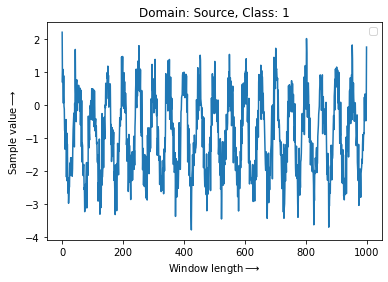

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


tensor(1)


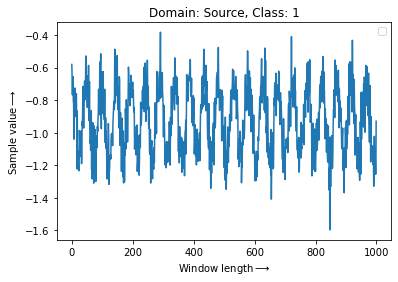

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


tensor(0)


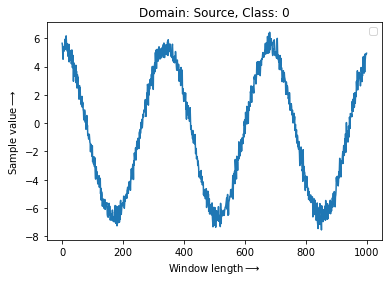

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


tensor(0)


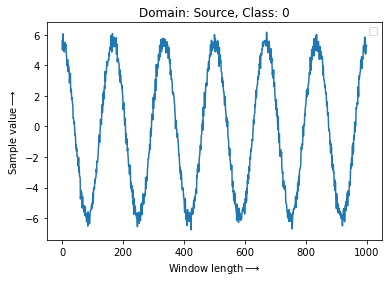

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


tensor(1)


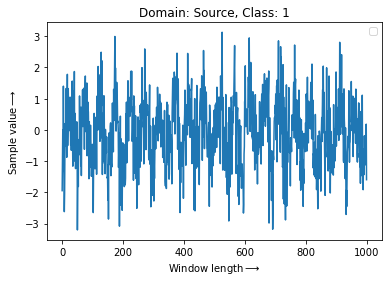

KeyboardInterrupt: 

In [45]:
print(len(source_loader["train"]))
dataloader_plot = source_loader["train"]
iter_source_loader = iter(dataloader_plot)
for _ in range(len(dataloader_plot)):
    data, label = iter_source_loader.next()
    for i in range(len(label)):
        print(label[i])
        fig = plt.figure()
        plt.plot(data[i,0,:])
        plt.title(f'Domain: Source, Class: {label[i]}')
        plt.xlabel("Window length$\longrightarrow$")
        plt.ylabel("Sample value$\longrightarrow$")
        plt.legend()
        plt.show()
        fig.savefig(f"ex_dummy_source_class_{label[i]}_ex_{i}.pdf", format='pdf')

In [38]:
class CNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNN, self).__init__()
        
        """
        formula [(W−K+2P)/S]+1.
        """
        self.conv1 = nn.Conv1d(input_size, 64, kernel_size=100, stride=1)#input: 1000
        self.conv2 = nn.Conv1d(64,32,kernel_size=10, stride = 1, padding=1)#input: [(1000-100+2*0)/1]+1 = 901
        self.batch1 =nn.BatchNorm1d(32)#input: [(901-10+2*1)/1]+1 = 894
        self.conv3 = nn.Conv1d(32,32,kernel_size=5, stride = 1, padding=1) #input:894
        self.batch2 =nn.BatchNorm1d(32)#input: [(894-5+2*1)/1]+1 = 892
        #self.fc1 = nn.Linear(32*892, output_size)

    def forward(self, x):
        x = F.selu(self.conv1(x)) #conv1
        x = self.conv2(x) #conv2
        x = F.selu(self.batch1(x)) #batch1
        x = self.conv3(x) #conv3
        x = F.selu(self.batch2(x)) #batch2
        x = torch.reshape(x,(x.shape[0],x.shape[1]*x.shape[2])) #flatten
        #x = self.fc1(x) #linear1
        output = x
        
        return output

In [ ]:
class CNN2(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNN2, self).__init__()
        
        """
        formula [(W−K+2P)/S]+1.
        """
        self.conv1 = nn.Conv1d(input_size, 25, kernel_size=25, stride=1) #output: [(1000-25+2*0)/1]+1 = 976
        self.maxpool1 = nn.MaxPool1d(2, stride=2) #output: [((976+2*0-1*(2-1))-1)/2]+1= 488
        self.conv2 = nn.Conv1d(25,25,kernel_size=25, stride = 1) #output: [(488-25+2*0)/1]+1 = 464
        self.maxpool2 = nn.MaxPool1d(2, stride=2) #output: [((464+2*0-1*(2-1)-1)/2]+1= 232
        self.conv3 = nn.Conv1d(25,25,kernel_size=25, stride = 1) #output: [(232-25+2*0)/1]+1 = 208
        self.maxpool3 = nn.MaxPool1d(2, stride=2) #output: [(208+2*0-1*(2-1)-1)/2]+1= 104
        self.conv4 = nn.Conv1d(25,25,kernel_size=25, stride = 1) #output: [(104-25+2*0)/1]+1 = 80 
        self.maxpool4 = nn.MaxPool1d(2, stride=2) #output: [(80+2*0-1*(2-1)-1)/2]+1= 40
        self.leakyrelu=torch.nn.LeakyReLU()
        #self.fc1 = nn.Linear(25*83, output_size)

    def forward(self, x):
        x = self.leakyrelu(self.conv1(x))
        x = self.maxpool1(x)
        x = self.leakyrelu(self.conv2(x))
        x = self.maxpool2(x)
        x = self.leakyrelu(self.conv3(x))
        x = self.maxpool3(x)
        x = self.leakyrelu(self.conv4(x))
        x = self.maxpool4(x)
        x = torch.reshape(x,(x.shape[0],x.shape[1]*x.shape[2])) #flatten
        output = x
        
        return output

In [ ]:
input_size = 1
input_fc_size = 32*892 #25*40 
hidden_fc_size_1 = 100
hidden_fc_size_2 = 3
output_size = 2


classifier_layer_1 = nn.Linear(input_fc_size, hidden_fc_size_1)
classifier_layer_2 = nn.Linear(hidden_fc_size_1, hidden_fc_size_2)
classifier_layer_3 = nn.Linear(hidden_fc_size_2, output_size)



model = CNN(input_size, output_size)


print(model)

print(classifier_layer_1)

print(classifier_layer_2)

print(classifier_layer_3)

In [ ]:
#from mmd_loss import MMD_loss
class MMD_loss(nn.Module):
    def __init__(self, kernel_mul = 2.0, kernel_num = 5):
        super(MMD_loss, self).__init__()
        self.kernel_num = kernel_num
        self.kernel_mul = kernel_mul
        self.fix_sigma = None
        return
    def gaussian_kernel(self, source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
        n_samples = int(source.size()[0])+int(target.size()[0])
        total = torch.cat([source, target], dim=0)
        
        total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
        L2_distance = ((total0-total1)**2).sum(2) 
        if fix_sigma:
            bandwidth = fix_sigma
        else:
            bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
        bandwidth /= kernel_mul ** (kernel_num // 2)
        bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
        kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
        return sum(kernel_val)

    def forward(self, source, target):
        batch_size = int(source.size()[0])
        kernels = self.gaussian_kernel(source, target, kernel_mul=self.kernel_mul, kernel_num=self.kernel_num, fix_sigma=self.fix_sigma)
        XX = kernels[:batch_size, :batch_size]
        YY = kernels[batch_size:, batch_size:]
        XY = kernels[:batch_size, batch_size:]
        YX = kernels[batch_size:, :batch_size]
        loss = torch.mean(XX + YY - XY -YX)
        return loss

In [ ]:
def forward(model, classifier_layer_1, classifier_layer_2, classifier_layer_3, data, labels_source, labels_target, criterion, MMD_loss, GAMMA):
        
        #Feature extraction
        outputs = model(data.float())

        #Classification
        x_src = classifier_layer_1(outputs[:batch_size, :])
        x_tar = classifier_layer_1(outputs[batch_size:, :])
        source_out = classifier_layer_2(x_src)
        target_out = classifier_layer_2(x_tar)
        source_pred = classifier_layer_3(source_out)
        target_pred = classifier_layer_3(target_out)
        
        #CE loss
        ce_loss = criterion(source_pred, labels_source)
        target_ce_loss = criterion(target_pred, labels_target)
        
        # MMD loss
        #mmd_loss_1 = mmd_loss.forward(x_src, x_tar)
        #mmd_loss_2 = mmd_loss.forward(source_out, target_out)
        #mmd_loss = mmd_loss_1 + mmd_loss_2
        
        

        #collect information about labels, predictions
        n_correct_source = 0
        n_correct_target = 0
        n_samples_source = 0
        n_samples_target = 0
        
        
        # plot list
        
        
        class_0_source_out = torch.empty((0,source_out.size()[1]))
        class_1_source_out = torch.empty((0,source_out.size()[1]))
        class_0_target_out = torch.empty((0,target_out.size()[1]))
        class_1_target_out = torch.empty((0,target_out.size()[1]))
        
        class_0_source_x = torch.empty((0,x_src.size()[1]))
        class_1_source_x = torch.empty((0,x_src.size()[1]))
        class_0_target_x = torch.empty((0,x_tar.size()[1]))
        class_1_target_x = torch.empty((0,x_tar.size()[1]))
        
        
        #SOURCE
        for i in range(len(labels_source)):
            
            #check correct prediction
            label_source = labels_source[i]
            output_source = torch.argmax(source_pred[i])
            if label_source == output_source:
                n_correct_source+=1
            n_samples_source+=1
            
            #sort x_src and source_out in arrays depending on their classes
            if label_source == 0:
                class_0_source_out = torch.cat((class_0_source_out, torch.unsqueeze(source_out[i,:],0)),0)
                class_0_source_x = torch.cat((class_0_source_x, torch.unsqueeze(x_src[i,:],0)), 0)
            elif label_source == 1:
                class_1_source_out = torch.cat((class_1_source_out, torch.unsqueeze(source_out[i,:],0)), 0)
                class_1_source_x = torch.cat((class_1_source_x, torch.unsqueeze(x_src[i,:],0)), 0)
                
        acc_total_source = 100.0 * n_correct_source / n_samples_source
            
        #TARGET
        for i in range(len(labels_target)):
            #check correct prediction
            label_target = labels_target[i]
            output_target = torch.argmax(target_pred[i])
            if label_target == output_target:
                n_correct_target+=1
            n_samples_target+=1
            
            #sort x_tar and target_out in arrays depending on their classes
            if label_target == 0:
                class_0_target_out = torch.cat((class_0_target_out, torch.unsqueeze(target_out[i,:],0)),0)
                class_0_target_x = torch.cat((class_0_target_x, torch.unsqueeze(x_tar[i,:],0)), 0)
            elif label_target == 1:
                class_1_target_out = torch.cat((class_1_target_out, torch.unsqueeze(target_out[i,:], 0)), 0)
                class_1_target_x = torch.cat((class_1_target_x, torch.unsqueeze(x_tar[i,:], 0)), 0)
        
        
        #MMD loss between elements of same class
        min_0_x = min(class_0_source_x.size()[0], class_0_target_x.size()[0])
        min_1_x = min(class_1_source_x.size()[0], class_1_target_x.size()[0])
        min_0_out = min(class_0_source_out.size()[0], class_0_target_out.size()[0])
        min_1_out = min(class_1_source_out.size()[0], class_1_target_out.size()[0])
        
        mmd_x_class_0 = MMD_loss.forward(class_0_source_x[:min_0_x,:],class_0_target_x[:min_0_x,:])
        mmd_x_class_1 = MMD_loss.forward(class_1_source_x[:min_1_x,:], class_1_target_x[:min_1_x,:])
        mmd_out_class_0 = MMD_loss.forward(class_0_source_out[:min_0_out,:], class_0_target_out[:min_0_out,:])
        mmd_out_class_1 = MMD_loss.forward(class_1_source_out[:min_1_out,:], class_1_target_out[:min_1_out,:])
        #mmd_loss = mmd_x_class_0 + mmd_x_class_1 + mmd_out_class_0 + mmd_out_class_1
        mmd_loss = mmd_out_class_0 + mmd_out_class_1
        
        min_0_x = min(class_0_source_x.size()[0], class_1_target_x.size()[0])
        min_1_x = min(class_1_source_x.size()[0], class_0_target_x.size()[0])
        min_0_out = min(class_0_source_out.size()[0], class_1_target_out.size()[0])
        min_1_out = min(class_1_source_out.size()[0], class_0_target_out.size()[0])
        
        mmd_x_dist_1 = MMD_loss.forward(class_0_source_x[:min_0_x,:], class_1_target_x[:min_0_x,:])
        mmd_x_dist_2 = MMD_loss.forward(class_1_source_x[:min_1_x,:], class_0_target_x[:min_1_x,:])
        mmd_out_dist_1 = MMD_loss.forward(class_0_source_out[:min_0_out,:], class_1_target_out[:min_0_out,:])
        mmd_out_dist_2 = MMD_loss.forward(class_1_source_out[:min_1_out,:], class_0_target_out[:min_1_out,:])
        mmd_dist = mmd_x_dist_1 + mmd_x_dist_2 + mmd_out_dist_1 + mmd_out_dist_2
        #total loss
        #loss = ce_loss + GAMMA * mmd_loss# - GAMMA * mmd_dist
        loss = ce_loss + GAMMA * (mmd_loss - mmd_dist)
        

        acc_total_target = 100.0 * n_correct_target / n_samples_target

        
        return loss, mmd_loss, target_ce_loss, acc_total_source, acc_total_target, class_0_source_out, class_1_source_out, class_0_target_out, class_1_target_out
    
    
    


In [ ]:
writer_graph = SummaryWriter('runs/Dataloader2/graph')
writer_train = SummaryWriter('runs/Dataloader2/train')
writer_val = SummaryWriter('runs/Dataloader2/val')
writer_test = SummaryWriter('runs/Dataloader2/test')
writer = {}
writer["train"] = writer_train
writer["val"] = writer_val
writer["test"] = writer_test


#define training params
num_epochs = 10
learning_rate = 0.1#0.008
GAMMA = 1  # 1000 more weight to transferability
SIGMA = [2,4,8]  # default 1

#define loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
MMD_loss = MMD_loss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


#dataloader for training and validation
dataloader_train = {}
dataloader_train["source"]=source_loader["train"]
dataloader_train["target"]=target_loader["test"]

#dataloader for testing
dataloader_val = {}
dataloader_val["source"]=source_loader["val"]
dataloader_val["target"]=target_loader["val"]

dataloaders = {}
dataloaders["train"] = dataloader_train
dataloaders["val"] = dataloader_val


#collect loss for each batch
loss_collected = 0
target_ce_loss_collected = 0
mmd_loss_collected = 0
loss_list = {}
loss_list['train']=[]
loss_list['val']=[]
loss_list['test'] = []

mmd_loss_list = []
target_ce_loss_list = []

#collect accuracy for each batch
acc_total_source_collected = 0
acc_total_target_collected = 0
accuracy_list={}
accuracy_list['train']=[]
accuracy_list['val']=[]
accuracy_list['test']=[]



phases = ["val", "train"]
# Train and Validate the model
for epoch in range(num_epochs):
    #plot mmd
    class_0_source_out_collect = torch.empty((0,3))
    class_1_source_out_collect = torch.empty((0,3))
    class_0_target_out_collect = torch.empty((0,3))
    class_1_target_out_collect = torch.empty((0,3))
    
    loss_collected = 0
    acc_collected = 0
    

    
    for phase in phases:
        iter_loader_source = iter(dataloaders[phase]["source"])
        iter_loader_target = iter(dataloaders[phase]["target"])
        
        for i in range(len(dataloaders[phase]["source"])):

            ########Forward pass########
            data_source, labels_source = iter_loader_source.next() #batch_size number of windows and labels from source domain
            data_target, labels_target = iter_loader_target.next() #batch_size number of windows from target domain
            data = torch.cat((data_source, data_target), dim=0) #concat the windows to 2*batch_size number of windows

            batch_size = len(labels_source) #take length of shorter dataoader which is the one from source domain (reason:train, val split)
                        
            if phase == "val":
                
                model.train(False) #no training
                
                with torch.no_grad():
                    loss, mmd_loss, target_ce_loss, acc_total_source, acc_total_target, class_0_source_out, class_1_source_out, class_0_target_out, class_1_target_out = forward(model, classifier_layer_1, classifier_layer_2, classifier_layer_3, data, labels_source, labels_target, criterion, MMD_loss, GAMMA)
                    
                    loss_collected += loss
                    mmd_loss_collected += mmd_loss
                    target_ce_loss_collected += target_ce_loss
                    acc_total_source_collected += acc_total_source
                    acc_total_target_collected += acc_total_target
                    
                    # collect plot values
                    class_0_source_out_collect = torch.cat((class_0_source_out_collect, class_0_source_out), 0)
                    class_1_source_out_collect = torch.cat((class_1_source_out_collect, class_1_source_out), 0)
                    class_0_target_out_collect = torch.cat((class_0_target_out_collect, class_0_target_out), 0)
                    class_1_target_out_collect = torch.cat((class_1_target_out_collect, class_1_target_out), 0)
                    
                    
            
            elif phase == "train":
                
                model.train(True) # training
                
                                
                ########Forward pass########
                loss, mmd_loss, target_ce_loss, acc_total_source, acc_total_target, _, _, _, _ = forward(model, classifier_layer_1, classifier_layer_2, classifier_layer_3, data, labels_source, labels_target, criterion, MMD_loss, GAMMA)
                
                loss_collected += loss
                mmd_loss_collected += mmd_loss
                target_ce_loss_collected += target_ce_loss
                acc_total_source_collected += acc_total_source
                acc_total_target_collected += acc_total_target

                ########Backward pass########
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                
        #plot
        if phase == "val" and (epoch ==0 or epoch ==1 or epoch ==2 or epoch == 4 or epoch ==6):

            fig = plt.figure()
            plt.gcf().set_size_inches((20, 20)) 
            ax = fig.add_subplot(projection='3d')

            m = [1,2,3,4]
            data = [class_0_source_out_collect, class_1_source_out_collect, class_0_target_out_collect, class_1_target_out_collect]
            data_legend = ["Source: Class 0", "Source: Class 1", "Target: Class 0", "Target: Class 1"]
            for i in range(4):
                ax.scatter(data[i][:,0], data[i][:,1], data[i][:,2], marker=m[i], label = data_legend[i])
            
            
            
            b = open(f'{epoch}_distribution.csv', 'w')
            a = csv.writer(b)
            a.writerows(data)
            b.close()
            
            ax.legend(prop={'size': 13}, loc='upper center')
            
            
            ax.set_xlabel('Neuron 1 $\longrightarrow$', rotation=0, labelpad=10, size=20)
            ax.set_ylabel('Neuron 2 $\longrightarrow$', rotation=0, labelpad=10, size=20)
            ax.set_zlabel('Neuron 3 $\longrightarrow$', rotation=0, labelpad=10, size=20)
            
            
            
            plt.rcParams.update({'font.size': 10})
            
            
            
            
            plt.show()
            fig.savefig(f"labeled_mmd_epoch{epoch}", format='pdf')       
                
                
    
        running_loss = loss_collected / len(dataloaders[phase]["source"])
        running_acc_source = acc_total_source_collected / len(dataloaders[phase]["source"])
        
        running_target_ce_loss = target_ce_loss_collected / len(dataloaders[phase]["source"])
        running_acc_target = acc_total_target_collected / len(dataloaders[phase]["source"])
        
        running_mmd_loss = mmd_loss_collected/ len(dataloaders[phase]["source"])
        
        loss_collected = 0
        target_ce_loss_collected = 0
        mmd_loss_collected = 0
        acc_total_source_collected = 0
        acc_total_target_collected = 0
        
        #list of train and validation loss for later plot
        if phase == "train":
            loss_list[phase].append(running_loss.detach())
            
            #loss and accuracy 
            #plot
            accuracy_list['test'].append(running_acc_target)
            mmd_loss_list.append(running_mmd_loss.detach())
            target_ce_loss_list.append(running_target_ce_loss.detach())
            # tensorboard
            writer["test"].add_scalar(f'test_loss', running_target_ce_loss, epoch)
            writer["test"].add_scalar(f'mmd_loss', running_mmd_loss, epoch)
            writer["test"].add_scalar(f'accuracy', running_acc_target, epoch)
            
        elif phase == "val":
            loss_list[phase].append(running_loss)
            
        #list of train and validation accuracy for later plot
        accuracy_list[phase].append(running_acc_source)
        
        #train and validation loss and accuracy tensorboard
        writer[phase].add_scalar(f'training loss', running_loss, epoch)
        writer[phase].add_scalar(f'accuracy', running_acc_source, epoch)



            

    print(f"Epoch {epoch+1}/{num_epochs} successfull")




In [ ]:
fig1 = plt.figure()
plt.title('Loss')
plt.plot(loss_list['train'], 'bo-', label = 'train', linewidth=1,markersize=0.1)
plt.plot(loss_list['val'], 'ro-', label = 'val', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig1.savefig('no_mmd_loss_source')



fig2 = plt.figure()
plt.title('Accuracy')
plt.plot(accuracy_list['train'], 'bo-', label = 'train', linewidth=1,markersize=0.1)
plt.plot(accuracy_list['val'], 'ro-', label = 'val', linewidth=1,markersize=0.1)
plt.plot(accuracy_list['test'], 'go-', label = 'test', linewidth=1,markersize=0.1)
plt.legend()
plt.show()
fig2.savefig('no_mmd_accuracy_source')

fig3 = plt.figure()
plt.title('CE-Loss Target')
plt.plot(target_ce_loss_list, 'bo-', linewidth=1,markersize=0.1)
plt.show()
fig3.savefig('no_mmd_ce_loss_target')

fig4 = plt.figure()
plt.title('MMD Loss')
plt.plot(mmd_loss_list, 'bo-', linewidth=1,markersize=0.1)
plt.show()
fig4.savefig('no_mmd_mmd_loss')


In [ ]:
with torch.no_grad():
    classes = ['class_0', 'class_1']
        
    #collect information about labels, predictions
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(2)]
    n_class_samples = [0 for i in range(2)]
    n_class_samples_out = [0 for i in range(2)]
        
    #iterate through bateches in test_loader
    for i, (window, labels) in enumerate(target_loader["test"]):
        #make predictions for each batch
        outputs = model(window.float())
        outputs = classifier_layer_1(outputs)
        outputs = classifier_layer_2(outputs)
        outputs = classifier_layer_3(outputs)
        #for each element in batch check if prediction is correct and collect total and correct predictions and labels
        for i in range(len(labels)):
            label = labels[i]
            output = torch.argmax(outputs[i])
            print(output)
            if label == output:
                n_correct+=1
                n_class_correct[label]+=1
                    
            n_samples+=1
            n_class_samples[label]+=1
            n_class_samples_out[output]+=1
        else:
            break
        
    #calculate total accuracy
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')
        
    #calculate class accuracy
    for i in range(4):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %') 
